In [1]:
from astropy.io import fits,ascii
from astropy import constants, units as u
import matplotlib.patches as mpatches
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.tri import Triangulation, TriAnalyzer
import os
from urllib import request

from ppxf.ppxf import ppxf, robust_sigma
import ppxf.ppxf_util as util
import ppxf.sps_util as lib
from vorbin.voronoi_2d_binning import voronoi_2d_binning
from plotbin.display_bins import display_bins
c = constants.c.to(u.km/u.s).value  # speed of light in km/s



In [188]:
multiAGNpath="/disk/bifrost/yuanze/multiAGN"
psname1="UGC"
psname2="2369"
obj=3
pos=["SE","SW","N"]
instru="KCWI"
stab = ascii.read(multiAGNpath+"/sources.list",format="ipac")
field=psname1+psname2
sentry = stab[stab["Field"]==field]
RA=sentry["RA"].value#[43.507814008,43.507573386,43.50724857]
Dec=sentry["Dec"].value#[14.9700775,14.9708075,14.97041556]
datapath=os.path.join(multiAGNpath,psname1+psname2)
z = sentry["z_sys"][obj-1]
path_ex = datapath #os.path.join(pyqsofit.__path__[0], '..', 'example')

path_out = os.path.join(datapath, '{}_1D'.format(instru.split("_")[0]))


In [189]:
rootname=field+"bin35-SNRcut"
gistoutpath=datapath+"/gist-KCWI/results/"+rootname

dirprefix=os.path.join(gistoutpath,rootname)

mask = fits.open(dirprefix+'_mask.fits')[1].data.MASK_DEFUNCT
maskedSpaxel = np.array(mask, dtype=bool)
#nmask=table_hdu[1].data.FLUX<0
#maskedSpaxel=nmask|masked
# Read bintable
table_hdu = fits.open(dirprefix+'_table.fits')
X           = np.array( table_hdu[1].data.X[~maskedSpaxel] )
Y           = np.array( table_hdu[1].data.Y[~maskedSpaxel] )
FLUX        = np.array( table_hdu[1].data.FLUX[~maskedSpaxel] ) 
binNum_long = np.array( table_hdu[1].data.BIN_ID[~maskedSpaxel] )
ubins       = np.unique( np.abs(binNum_long) )
pixelsize   = table_hdu[0].header['PIXSIZE']


## Reading result

In [190]:
hdu = fits.open(dirprefix+'_kin.fits')
sfh_hdu=fits.open(dirprefix+'_sfh.fits')

result      = np.zeros((len(ubins),5))
result[:,0] = np.array( hdu[1].data.V     )
result[:,1] = np.array( hdu[1].data.SIGMA )
result[:,2] = np.array( hdu[1].data.FORM_ERR_V)
result[:,3] = np.array( hdu[1].data.FORM_ERR_SIGMA)
result[:,4] = np.array( sfh_hdu[1].data.AGE)

result_long  = np.zeros( (len(binNum_long), result.shape[1]) ); result_long[:,:] = np.nan
for i in range( len(ubins) ):
    idx = np.where( ubins[i] == binNum_long )[0]
    result_long[idx,:]  = result[i,:]
result = result_long
#result[:,0] = result[:,0] - np.nanmedian( result[:,0] )


# Read Spectra
Spectra    = fits.open(dirprefix+'_BinSpectra.fits')[1].data.SPEC
ESpectra = fits.open(dirprefix+'_BinSpectra.fits')[1].data.ESPEC
Lambda     = fits.open(dirprefix+'_BinSpectra.fits')[2].data.LOGLAM
nbins           = Spectra.shape[0]

# Read kinematics bestfit
kinBestfit = fits.open(dirprefix+'_kin-bestfit.fits')[1].data.BESTFIT
kinLambda  = fits.open(dirprefix+'_kin-bestfit.fits')[2].data.LOGLAM

sfhBestfit = fits.open(dirprefix+'_sfh-bestfit.fits')[1].data.BESTFIT
sfhLambda  = fits.open(dirprefix+'_sfh-bestfit.fits')[2].data.LOGLAM
#self.sfhGoodpix = fits.open(dirprefix+'_sfh-bestfit.fits')[3].data.GOODPIX

bin_sel_obj=[196,157,0]
bin_sel=bin_sel_obj[obj-1]
idx = np.where( bin_sel == binNum_long )[0]

Xc,Yc=np.mean(X[idx]),np.mean(Y[idx])

padding=0.0
xmin = np.nanmin(X)-padding;  xmax = np.nanmax(X)+padding
ymin = np.nanmin(Y)-padding;  ymax = np.nanmax(Y)+padding
npixels_x = int( np.round( (xmax - xmin)/pixelsize ) + 1 )
npixels_y = int( np.round( (ymax - ymin)/pixelsize ) + 1 )
i = np.array( np.round( (X - xmin)/pixelsize ), dtype=int )
j = np.array( np.round( (Y - ymin)/pixelsize ), dtype=int )
#image = np.full( (npixels_x, npixels_y), np.nan )
#image[i,j] = result[:,0]


/tmp/ipykernel_2924065/3710083958.py:50: RuntimeWarning: divide by zero encountered in log10
  mag_flux=np.log10( FLUX)


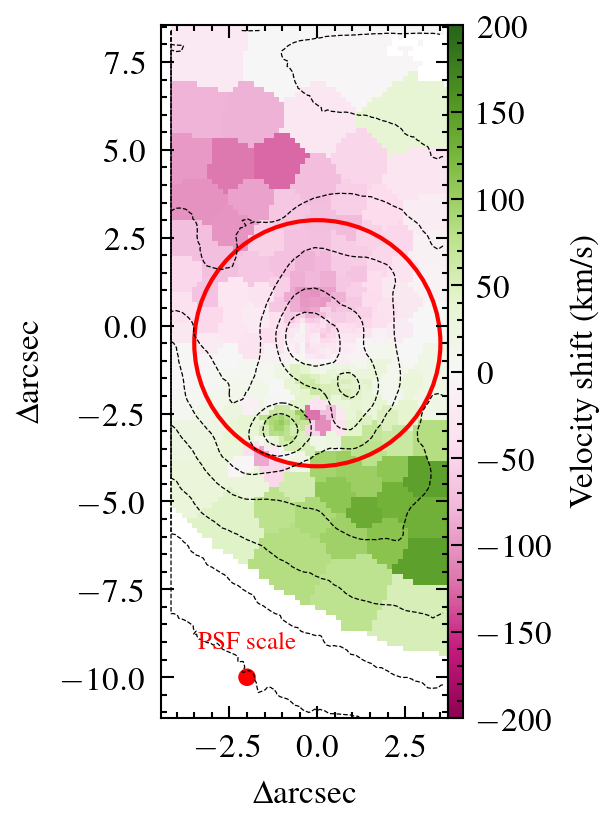

In [311]:
import scienceplots
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.style.use(["science"])
plt.rcParams.update({
    "font.family": "dejavu sans",   # specify font family here
    "font.serif": ["Times"],  # specify font here
    "font.size":8,
"legend.fancybox":True})
vshift = np.full( (npixels_x, npixels_y), np.nan )
vshift[i,j] = result[:,0]

fig,ax=plt.subplots(1,1,figsize=(5, 3),dpi=300)


vmin=-200
vmax=200
cmap = plt.cm.PiYG
im=ax.imshow(np.rot90(vshift), cmap=cmap, interpolation=None, vmin=vmin, vmax=vmax, \
            extent=[xmin-pixelsize/2, xmax+pixelsize/2, ymin-pixelsize/2, ymax+pixelsize/2] )

divider = make_axes_locatable(ax)
# Append axes to the right of ax, with 2% width and no padding
cax = divider.append_axes("right", size="5%", pad=0.0)

# Create a colorbar in the new axes
cb=fig.colorbar(im, cax=cax)
#cb.set_label(r"Velocity dispersion (km/s)")
cb.set_label(r"Velocity shift (km/s)")

XY_Triangulation = Triangulation(X-pixelsize/2, Y-pixelsize/2)
XY_Triangulation.set_mask( TriAnalyzer(XY_Triangulation).get_flat_tri_mask(0.01) )
from matplotlib.patches import Circle
#resolution=mpatches.Ellipse((0.5,0.5),0.025,0.025,color='red',fill=True,transform=ax.transAxes,lw=0.01)
center=(-2,-10)
circle = Circle(center, 0.25, edgecolor='none', facecolor='red')

ax.add_artist(circle)

center=(0,-0.5)
circle2 = Circle(center, 3.5, edgecolor='red', facecolor='none')
ax.add_artist(circle2)

ax.annotate('PSF scale', xy=center, xytext=(-2, -9),
            arrowprops=dict(facecolor='red',edgecolor='none', shrink=0.1,width=0., headwidth=0.),
            fontsize=6, va='center',ha='center',color="red")

contour_offset=-0.8
mag_flux=np.log10( FLUX)
finite_mask=np.isfinite(mag_flux)
mag_flux[~finite_mask] = -99
levels = np.arange( np.nanmedian(mag_flux) + contour_offset, np.nanmax(mag_flux)-0.4, 0.3 )
ax.tricontour(XY_Triangulation, mag_flux, levels=levels, linewidths=0.3, colors='k')
ax.set_xlabel(r"$\Delta$arcsec")
ax.set_ylabel(r"$\Delta$arcsec")
#ax.scatter(np.float64(X[idx]), np.float64(Y[idx]),c="r",s=0.5)
fig.savefig(datapath+"/fig/kin_map_vshift_{}.pdf".format(instru))

/tmp/ipykernel_2924065/3346964567.py:44: RuntimeWarning: divide by zero encountered in log10
  mag_flux=np.log10( FLUX)


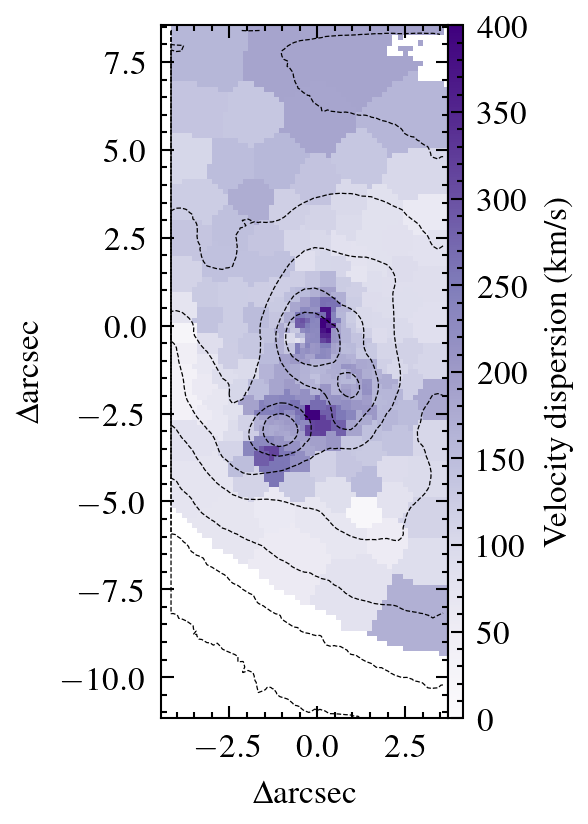

In [219]:
import scienceplots
import matplotlib
plt.style.use(["science"])
plt.rcParams.update({
    "font.family": "dejavu sans",   # specify font family here
    "font.serif": ["Times"],  # specify font here
    "font.size":8,
"legend.fancybox":True})

vdisp = np.full( (npixels_x, npixels_y), np.nan )
vdisp[i,j] = result[:,1]

fig,ax=plt.subplots(1,1,figsize=(5, 3),dpi=300)


vmin=0
vmax=400
cmap = plt.cm.Purples
im=ax.imshow(np.rot90(vdisp), cmap=cmap, interpolation=None, vmin=vmin, vmax=vmax, \
            extent=[xmin-pixelsize/2, xmax+pixelsize/2, ymin-pixelsize/2, ymax+pixelsize/2] )
divider = make_axes_locatable(ax)
# Append axes to the right of ax, with 2% width and no padding
cax = divider.append_axes("right", size="5%", pad=0.0)

# Create a colorbar in the new axes
cb=fig.colorbar(im, cax=cax)
#cb.set_label(r"Velocity dispersion (km/s)")
cb.set_label(r"Velocity dispersion (km/s)")

XY_Triangulation = Triangulation(X-pixelsize/2, Y-pixelsize/2)
XY_Triangulation.set_mask( TriAnalyzer(XY_Triangulation).get_flat_tri_mask(0.01) )
from matplotlib.patches import Circle
#resolution=mpatches.Ellipse((0.5,0.5),0.025,0.025,color='red',fill=True,transform=ax.transAxes,lw=0.01)
center=(-4,4)
#circle = Circle(center, pixelsize, edgecolor='none', facecolor='red')

#ax.add_artist(circle)

#ax.annotate('PSF scale', xy=center, xytext=(-1.5, 4),
#            arrowprops=dict(facecolor='red',edgecolor='none', shrink=0.1,width=1, headwidth=5),
#            fontsize=8, va='center',ha='center',color="red")

contour_offset=-0.8
mag_flux=np.log10( FLUX)
finite_mask=np.isfinite(mag_flux)
mag_flux[~finite_mask] = -99
levels = np.arange( np.nanmedian(mag_flux) + contour_offset, np.nanmax(mag_flux)-0.4, 0.3 )
ax.tricontour(XY_Triangulation, mag_flux, levels=levels, linewidths=0.3, colors='k')
ax.set_xlabel(r"$\Delta$arcsec")
ax.set_ylabel(r"$\Delta$arcsec")
#ax.scatter(np.float64(X[idx]), np.float64(Y[idx]),c="r",s=0.5)
fig.savefig(datapath+"/fig/kin_map_vdisp_{}.pdf".format(instru))

/tmp/ipykernel_2924065/2924801152.py:44: RuntimeWarning: divide by zero encountered in log10
  mag_flux=np.log10( FLUX)


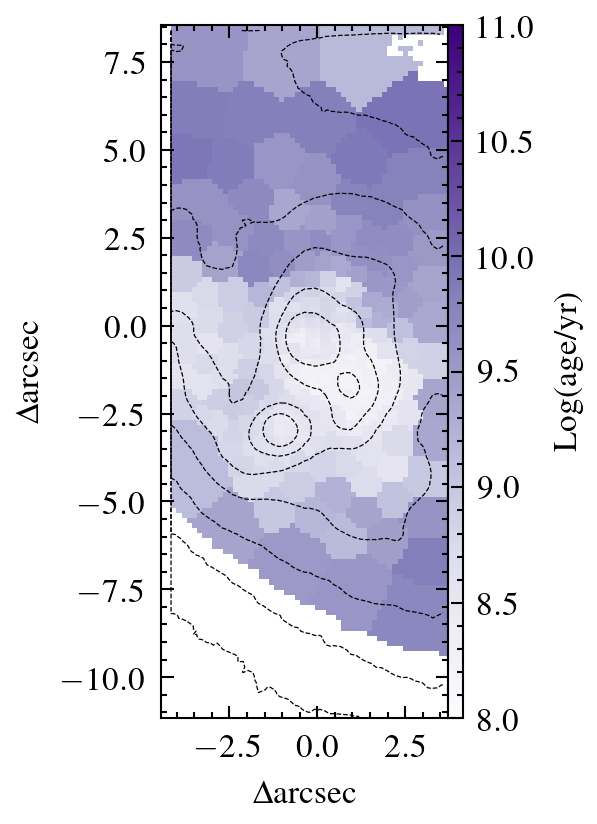

In [211]:
import scienceplots
import matplotlib
plt.style.use(["science"])
plt.rcParams.update({
    "font.family": "dejavu sans",   # specify font family here
    "font.serif": ["Times"],  # specify font here
    "font.size":8,
"legend.fancybox":True})

image = np.full( (npixels_x, npixels_y), np.nan )
image[i,j] = result[:,4]

fig,ax=plt.subplots(1,1,figsize=(5, 3),dpi=300)


vmin=8.0
vmax=11
cmap = plt.cm.Purples
im=ax.imshow(np.log10(np.rot90(image*1e9)), cmap=cmap, interpolation=None, vmin=vmin, vmax=vmax, \
            extent=[xmin-pixelsize/2, xmax+pixelsize/2, ymin-pixelsize/2, ymax+pixelsize/2] )
divider = make_axes_locatable(ax)
# Append axes to the right of ax, with 2% width and no padding
cax = divider.append_axes("right", size="5%", pad=0.0)

# Create a colorbar in the new axes
cb=fig.colorbar(im, cax=cax)
#cb.set_label(r"Velocity dispersion (km/s)")
cb.set_label(r"Log(age/yr)")

XY_Triangulation = Triangulation(X-pixelsize/2, Y-pixelsize/2)
XY_Triangulation.set_mask( TriAnalyzer(XY_Triangulation).get_flat_tri_mask(0.01) )
from matplotlib.patches import Circle
#resolution=mpatches.Ellipse((0.5,0.5),0.025,0.025,color='red',fill=True,transform=ax.transAxes,lw=0.01)
center=(-4,4)
#circle = Circle(center, pixelsize, edgecolor='none', facecolor='red')

#ax.add_artist(circle)

#ax.annotate('PSF scale', xy=center, xytext=(-1.5, 4),
#            arrowprops=dict(facecolor='red',edgecolor='none', shrink=0.1,width=1, headwidth=5),
#            fontsize=8, va='center',ha='center',color="red")

contour_offset=-0.8
mag_flux=np.log10( FLUX)
finite_mask=np.isfinite(mag_flux)
mag_flux[~finite_mask] = -99
levels = np.arange( np.nanmedian(mag_flux) + contour_offset, np.nanmax(mag_flux)-0.4, 0.3 )
ax.tricontour(XY_Triangulation, mag_flux, levels=levels, linewidths=0.3, colors='k')
ax.set_xlabel(r"$\Delta$arcsec")
ax.set_ylabel(r"$\Delta$arcsec")
#ax.scatter(np.float64(X[idx]), np.float64(Y[idx]),c="r",s=0.5)
fig.savefig(datapath+"/fig/sfh_map_age_{}.pdf".format(instru))

In [43]:
lines={'[N II]':[6548.,6583.],"[S II]":[6716.,6731.] ,'[O III]':[4959,5007],'[O II]':[3727], r"H$\alpha$":[6563], r"H$\beta$":[4861.],"CaII":[8498, 8542, 8662]}#,"Fe II":[6491.28,6385.45,6598.3]}

In [89]:
hdu[1].data.V.shape

(332,)

(0.7735007720194301, 3.63631677803845)

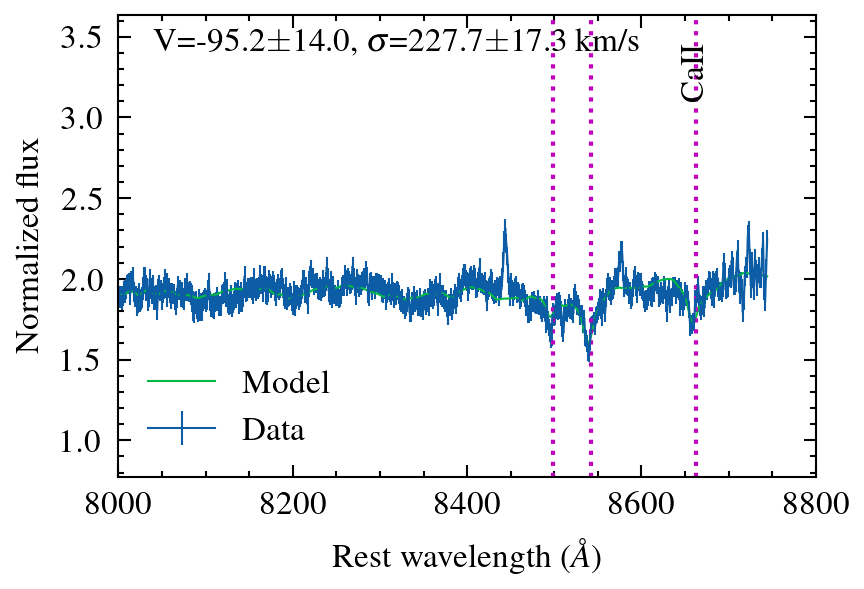

In [213]:
plt.style.use(["science"])
plt.rcParams.update({
    "font.family": "dejavu sans",   # specify font family here
    "font.serif": ["Times"],  # specify font here
    "font.size":8,
"legend.fancybox":True})
fig, ax = plt.subplots(1, 1,figsize=(3,2), dpi=300)
bin_sel=100
rlinec= (1+0.0318)/(z+1)
ax.errorbar(np.exp(Lambda)*rlinec,Spectra[bin_sel,:],yerr=ESpectra[bin_sel,:],lw=0.5,label="Data")
#ax.plot(np.exp(Lambda)*rlinec,ESpectra[bin_sel,:],lw=0.5,label="Error")

ax.plot(np.exp(kinLambda)*rlinec,kinBestfit[bin_sel,:],lw=0.5,label="Model")
ax.set_ylabel("Normalized flux")
ax.set_xlabel(r"Rest wavelength ($\AA$)")
xlow=8000
xhigh=8800
yup=np.median(Spectra[bin_sel,4000:6000])*2.0
ylow=np.min(Spectra[bin_sel,4000:6000])*0.5

keys=lines.keys()
for ind,key in enumerate(keys):
    for line in lines[key]:
        if line < xhigh and line > xlow:
            ax.axvline(line,ls=":",c="m")
#            masktmp = (x.value < ((1+redshift)*line*(1+dlam))) & (x.value > ((1+redshift)*line*(1-dlam)))
#            mask= mask | masktmp
           # print(x[mask])
    if line < xhigh and line > xlow:
        ax.text(line, 0.85*yup,key, rotation=90,verticalalignment='bottom',horizontalalignment='center')

rstring=rf"V={hdu[1].data.V[bin_sel]:.1f}$\pm${hdu[1].data.FORM_ERR_V[bin_sel]:.1f}, $\sigma$={hdu[1].data.SIGMA[bin_sel]:.1f}$\pm${hdu[1].data.FORM_ERR_SIGMA[bin_sel]:.1f} km/s"
ax.text(0.05,0.97, rstring, color='black', ha='left', va='top',transform=ax.transAxes)
#ax.text(0.05,0.90, f"Object {obj} ({pos[obj-1]})", color='black', ha='left', va='top',transform=ax.transAxes)

ax.legend(loc="lower left")
ax.set_xlim([xlow,xhigh])
ax.set_ylim([ylow,yup])

#fig.savefig(datapath+f"/fig/fitted_spec_kin_obj{obj}_{instru}.pdf")

In [75]:
np.max(Spectra[bin_sel,5000:])

12.82057930948131

In [41]:
def logMbh(sigma):
    return -0.509+4.384*np.log10(sigma/200)

def logMbhSE(sigma):
    return np.sqrt(0.049**2+np.log10(sigma/200)**2*0.287**2)
vdisp=np.array([139,93,127.6])

Mbh=10**logMbh(vdisp)*1e9

MbhSE=logMbhSE(vdisp)*Mbh

print(np.array(Mbh))
print(np.array(MbhSE))

[62843647.41228728 10792293.4468872  43185092.63372901]
[4195798.48817195 1157846.86365119 3213981.97631878]


In [221]:
np.zeros(1)[0]

0.0

In [278]:
def circularly_averaged_radial_distribution(Map2d,center,num_bins,rmax,rmin=0,Type="Mstar",pix2world=None,**kwag):
    # Determine the center of the 2D map
    # all in kpc unit
    #center = np.array(stellar_mass_map.shape) // 2
    total_in_rmax=0
    # Create coordinate grids
    y, x = np.indices(Map2d.shape)
    r = np.sqrt((x - center[0])**2 + (y - center[1])**2)
    
    
    #r=np.rot90(r.T)
    # Define the bins
    r_max = rmax
    bins = np.linspace(rmin, r_max, num_bins + 1)
    
    # Digitize the radial distances into bins
    bin_indices = np.digitize(r, bins) - 1
    #print(r)
    #print(bin_indices)
    fig=plt.figure(dpi=300)
    im=plt.imshow(np.rot90(bin_indices))
    #plt.imshow(np.rot90(Map2d),origin="lower")
    ax=plt.gca()
    divider = make_axes_locatable(ax)
    # Append axes to the right of ax, with 2% width and no padding
    cax = divider.append_axes("right", size="5%", pad=0.0)
    cb=fig.colorbar(im, cax=cax)
    # Calculate the circularly averaged stellar mass in each bin
    radial_distribution = np.zeros(num_bins)
    omegasum=0
    if Type=="NaImdot":
        mdot_temp=1.4*constants.u.to(u.Msun).value*Map2d/u.cm.to(u.kpc)**2*np.abs(vshift)*u.km.to(u.kpc)/u.s.to(u.yr)*Rshell #\mu m_p N_i v_i, convert NH from cm-2 to kpc-2
    if Type=="NaIEdot":
        mdot_temp=1.4*constants.u.to(u.g).value*Map2d*np.abs(vshift)*u.km.to(u.cm)*Rshell*u.kpc.to(u.cm)*(np.abs(vshift)*u.km.to(u.cm))**2 #\mu m_p N_i v_i*v_i**2, convert NH from cm-2 to kpc-2
    for i in range(num_bins):
        if Type=="Mstar":
            radial_distribution[i] = (10**Map2d[bin_indices == i]).mean()
            total_in_rmax+=np.nansum(10**Map2d[bin_indices == i])
        elif Type=="mag":
            radial_distribution[i] = np.nanmean(10**(Map2d[bin_indices == i]/-2.5))
            total_in_rmax+=np.nansum(10**Map2d[bin_indices == i])
        elif Type=="NaImdot":
            costheta2=np.sqrt(1-(bins[i]*pix2world/Rshell)**2)
            Omega=(pix2world/Rshell)**2/costheta2 #solid angle element for each pixel at distance bins[i] away from center
            #vr=vobs/costheta2=vobs/np.sqrt(1-(bins[i]*pix2world/Rshell)**2))
            radial_distribution[i]=np.nanmean(mdot_temp[bin_indices == i]/costheta2)# Mdot per Omega, here cos(theta_2) is a velocity correction factor
            total_in_rmax+=np.nansum(mdot_temp[bin_indices == i]/costheta2*Omega)#
        elif Type=="NaIEdot":
            costheta2=np.sqrt(1-(bins[i]*pix2world/Rshell)**2)
            Omega=(pix2world/Rshell)**2/costheta2 #solid angle element for each pixel at distance bins[i] away from center
            print(costheta2)
            omegasum+=np.nansum(np.ones(np.shape(mdot_temp[bin_indices == i]))*Omega)
            #vr=vobs/costheta2=vobs/np.sqrt(1-(bins[i]*pix2world/Rshell)**2))
            radial_distribution[i]=np.nanmean(mdot_temp[bin_indices == i]/costheta2**3)
            total_in_rmax+=np.nansum(mdot_temp[bin_indices == i]/costheta2*Omega)
        elif Type=="v-corr sum":
            costheta2=np.sqrt(1-(bins[i]*pix2world/Rshell)**2)
            radial_distribution[i]=np.nanmean(Map2d[bin_indices == i]/costheta2)
            total_in_rmax+=np.nansum(Map2d[bin_indices == i])
        elif Type=="simple sum":
            radial_distribution[i]=np.nansum(Map2d[bin_indices == i])
            total_in_rmax+=np.nansum(Map2d[bin_indices == i])
        elif Type=="simple average":
            radial_distribution[i]=np.nanmean(Map2d[bin_indices == i])
            total_in_rmax+=np.nanmean(Map2d[bin_indices == i])
        elif Type=="Vshear":
            radial_distribution[i]=0.5*(np.abs(np.percentile(Map2d[bin_indices == i],2.5)-np.percentile(Map2d[bin_indices == i],97.5)))
            total_in_rmax+=np.nanmean(Map2d[bin_indices == i])
        else:
            raise("Error: invalid switches")
   # if Type=="mdot":
        

    return bins[1:], radial_distribution,bin_indices, total_in_rmax,omegasum


total mass -1.51e+02
radius of circle: 3.75


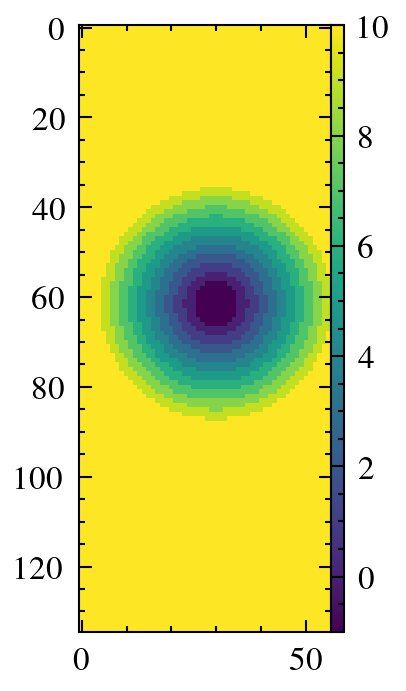

In [301]:
from astropy.cosmology import Planck18
# Example usage
pixscale=0.146 #KCWI pixel scale
kpc_per_pix=pixscale*Planck18.kpc_proper_per_arcmin(0.032).value/60
#stellar_mass_map = Zm  # Replace with your actual stellar mass map
num_bins = 10  # Number of radial bins
num_of_pix = 3.75/pixscale #radius of circle (pix)

Rshell=0.75*Planck18.kpc_proper_per_arcmin(0.032).value/60
obj3=np.array([-0.5,0.0])
obj2=np.array([1.2,-1.4])
obj1=np.array([-0.75,-2.6])
#obj=objects['x']*pix_scale]
center=(obj3-np.array([ymin,xmin]))/pixscale
#center=(np.array([-0.9,-1.25])-np.array([ymin,xmin]))/pix_scale
radii, radial_distribution,bin_indices,total_in_rmax,omegasum = circularly_averaged_radial_distribution(vshift, center,num_bins,num_of_pix,rmin=5,Type="Vshear",
                                                                                        pix2world=kpc_per_pix)#wcs.pixel_scale_matrix[1,1]*3600)
print("total mass %.2e"%total_in_rmax)
print("radius of circle:",pixscale*num_of_pix)

In [303]:
radial_distribution

array([ 68.20813558,  81.28621697,  77.35438301,  63.38294318,
        93.00771757,  87.85480657,  75.15597207,  72.31519994,
        83.56892576, 100.26609244])

In [308]:
vrot=radial_distribution[-3]/np.sin(52/180*np.pi)

In [309]:
0.35/0.79*vrot

40.65728744681131

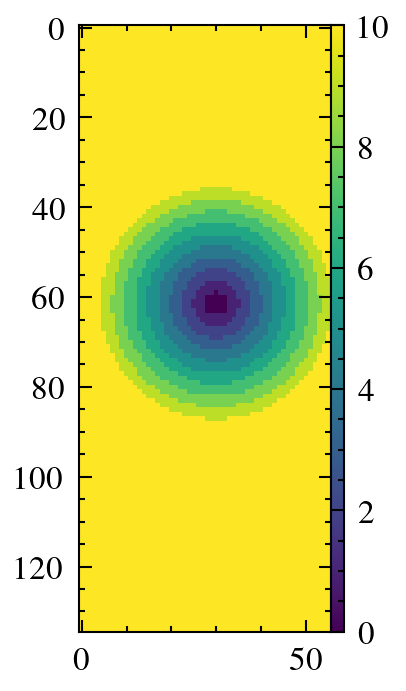

In [282]:
radii, radial_distribution,bin_indices,total_in_rmax,omegasum = circularly_averaged_radial_distribution(vdisp, center,num_bins,num_of_pix,Type="simple average",
                                                                                        pix2world=kpc_per_pix)

In [283]:
radial_distribution

array([245.78739156, 212.06676082, 185.00789236, 161.86096984,
       160.2052871 , 155.15896553, 144.39244948, 126.56555408,
       122.8484776 , 119.88388962])

In [289]:
Mdyn=2*2.33*u.kpc*((104.41*u.km/u.s)**2+1.35*(145*u.km/u.s)**2)/(constants.G)

In [292]:
rdist=3*u.kpc
vesc=np.sqrt(2*constants.G*Mdyn*(1+np.log(10))/3/rdist)
vesc

<Quantity 366.54574577 km / s>

In [310]:
vesc=np.sqrt(2*(91.76*u.km/u.s)**2*(1+np.log(10)))
vesc,vesc*0.35/0.79

(<Quantity 235.82802335 km / s>, <Quantity 104.48076984 km / s>)

In [291]:
Mdyn.to(u.Msun)

<Quantity 4.25651115e+10 solMass>